# DataSciCon.tech

### IMPORTS

In [1]:
%matplotlib inline

from datetime import date, datetime, timedelta
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stemgraphic import stem_graphic
import seaborn as sns

# Data

### Loading the data

In [2]:
df = pd.read_csv('home_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Preliminary data munging

In [5]:
df['renovated'] = df.yr_renovated>=1

In [6]:
df.drop('date',axis=1, inplace=True)

In [7]:
df.shape

(21613, 21)

### Simulating invalid data

In [9]:
import random

random.seed(42)

In [10]:
PCT = 0.01
i = [random.choice(range(df.shape[0]-1)) for _ in range(int(df.shape[0] * PCT))]

In [11]:
df.iloc[i, 17] = df.iloc[i, 17].abs()

### Feature Engineering

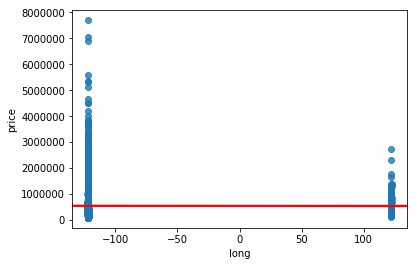

In [13]:
sns.regplot(x='long', y='price', data=df, line_kws={'color':'r'});

In [14]:
df['lat_from_center_eng_'] = (47.62 - df.lat).abs()
df['long_from_center_eng_'] = (-122.32 - df.long).abs()

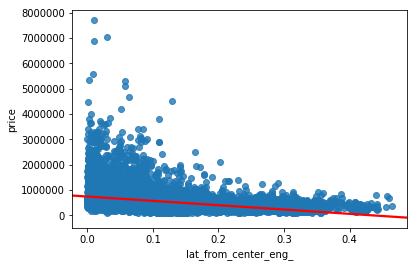

In [15]:
sns.regplot(x='lat_from_center_eng_', y='price', data=df, line_kws={'color':'r'});

In [16]:
df['sqft_living_log_eng_'] = df['sqft_living'].apply(log)

In [17]:
df.drop(['lat','long'], axis=1, inplace=True)

## Model

### Multivariate Linear regression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_all = df.copy()

In [21]:
#X_all.iloc[i, j] = np.NaN
#X_all.iloc[i, 19] = np.NaN

In [22]:
import missingno as msno

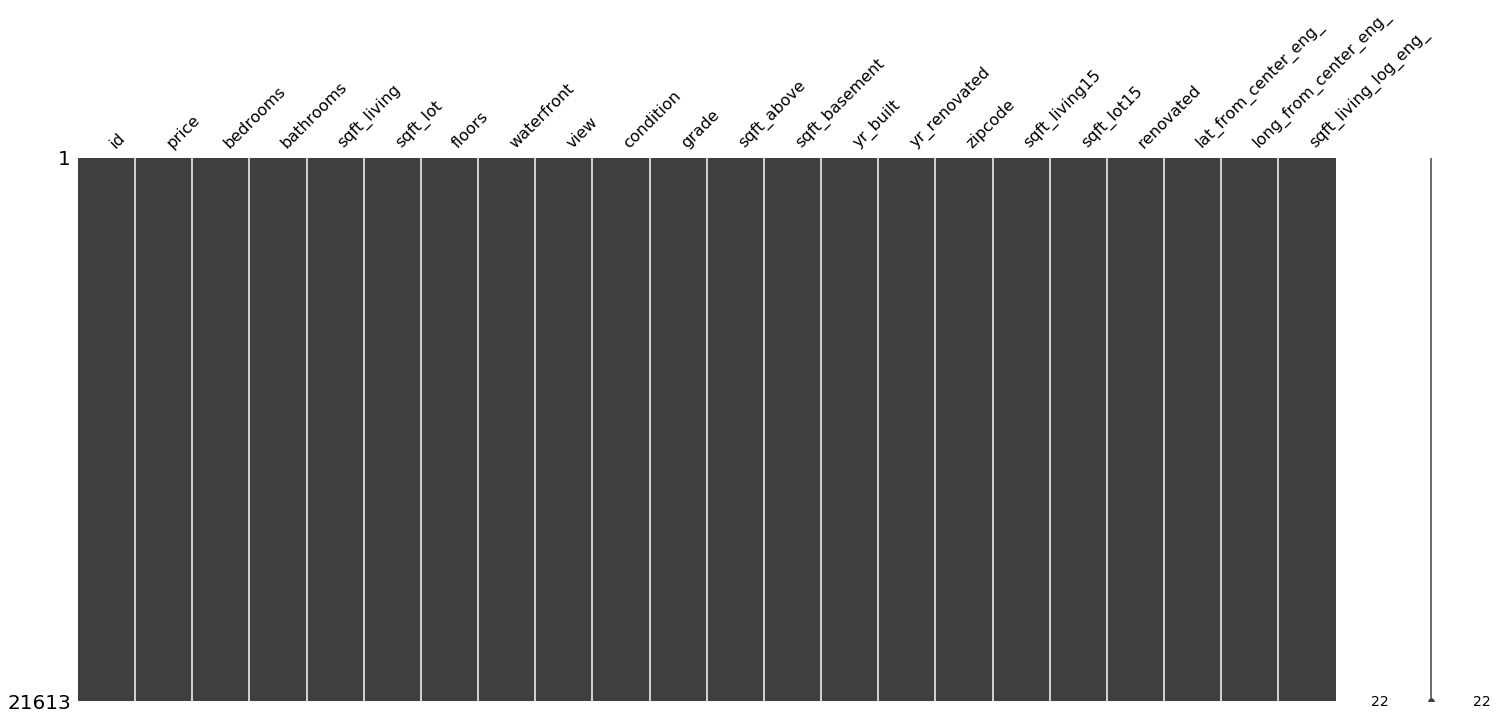

In [23]:
msno.matrix(X_all)

# imputation

In [24]:
#X_all.dropna(how="any", inplace=True)
#X_all.fillna(0, inplace=True)
#X_all.fillna(X_all.mean(), inplace=True)
#X_all.fillna(X_all.median(), inplace=True)  # strawman imputation for continuous

# Feature Selection

In [25]:
from sklearn.feature_selection import RFE

In [26]:
lr = LinearRegression()
rfe = RFE(lr, 9)
rfe = rfe.fit(X_all.drop("price", axis=1), X_all.price)

In [27]:
print(X_all.drop("price", axis=1).columns[rfe.support_])
print(rfe.ranking_)
print(rfe.support_)

Index(['bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'renovated', 'lat_from_center_eng_', 'sqft_living_log_eng_'],
      dtype='object')
[13  2  1  6 12  1  1  1  1  1  7  8  3  4  5 10 11  1  1  9  1]
[False False  True False False  True  True  True  True  True False False
 False False False False False  True  True False  True]


In [28]:
X = X_all[X_all.drop("price", axis=1).columns[rfe.support_]]

# Train / test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, X_all.price, test_size=0.25, random_state=42)

In [30]:
X_train.shape

(16209, 9)

# Train the model

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Metrics

Storing a few extra piece of informations in our model

In [32]:
lr.version = datetime.today()

In [33]:
lr.cv = lr.score(X_test, y_test)

In [34]:
print(lr.version, lr.cv)

2018-11-29 16:27:39.089864 0.6680494399956315


### Visualisation

In [ ]:
ax = plt.scatter(lr.predict(X_train), lr.predict(X_train) - y_train, c='r', s=15, alpha=0.2)
plt.scatter(lr.predict(X_test), lr.predict(X_test) - y_test, c='b', s=15, alpha=0.2)

# Model coefficients

In [35]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [36]:
lr.coef_

array([   42414.19881555,   -42421.11406161,   601941.99256   ,
          69908.74065643,    50044.53870402,   118055.69262922,
         126089.64025094, -1301388.17891431,   178092.27763931])

In [37]:
lr.intercept_

-1777773.5619582837

In [38]:
X.columns

Index(['bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'renovated', 'lat_from_center_eng_', 'sqft_living_log_eng_'],
      dtype='object')

In [39]:
house1 = X[-1:]
print(lr.predict(house1))
print("---------------")
print( house1, X_all[-1:]["price"])

[345756.93572019]
---------------
       bathrooms  floors  waterfront  view  condition  grade  renovated  \
21612      0.750   2.000           0     0          3      7      False   

       lat_from_center_eng_  sqft_living_log_eng_  
21612                 0.026                 6.928   21612    325000
Name: price, dtype: int64


Not only did the order of features change, but the features themselves are different. Just because <span style="color: red">1% of the data has the wrong geocoding</span>. Due to this, the next line, which worked with the uncorrupted data, will now error out.

In [40]:
print(lr.intercept_
      + house1.bathrooms * lr.coef_[0]
      + house1.waterfront * lr.coef_[1]
      + house1.view * lr.coef_[2]
      + house1.condition * lr.coef_[3]
      + house1.grade * lr.coef_[4]
      + house1.renovated * lr.coef_[5]
      + house1.lat_from_center_eng_ * lr.coef_[6] 
      + house1.long_from_center_eng_ * lr.coef_[7]
      + house1.sqft_living_log_eng_ * lr.coef_[8])

AttributeError: 'DataFrame' object has no attribute 'long_from_center_eng_'

In [41]:
pd.Series(dict(zip(X.columns, lr.coef_))).sort_values()

lat_from_center_eng_   -1301388.179
floors                   -42421.114
bathrooms                 42414.199
condition                 50044.539
view                      69908.741
grade                    118055.693
renovated                126089.640
sqft_living_log_eng_     178092.278
waterfront               601941.993
dtype: float64

# Previous values

<pre>
lat_from_center_eng_   -1268195.034
long_from_center_eng_   -218764.288
bathrooms                 30786.124
condition                 52972.204
view                      69006.872
grade                    113730.003
renovated                119986.357
sqft_living_log_eng_     199563.355
waterfront               600740.084
</pre>

Expecting 325,000.00 and got 392,391.98